<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/GIT/Fine_tune_GIT_on_an_image_captioning_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [3]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00


## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

As I'm a football fan I simply went to the Wikipedia page of a few of the most famous footballers, and took a captioned image from their respective pages.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [1]:
path = !pwd
root = path[0] + '/'
print(root)
!rm -rf sample_data

/content/


In [ ]:
import pandas as pd
import csv
import json

root = path[0] + "/blip/"

with open('', 'r') as csvfile, open(root + 'metadata.jsonl', 'w') as jsonfile:
    fieldnames = ("file_name", "text")
    reader = csv.DictReader(csvfile, fieldnames)
    for row in list(reader)[1:]:
        json.dump(row, jsonfile)
        jsonfile.write('\n')
        jsonfile.flush()

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

In [5]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=root, split="train")

Resolving data files:   0%|          | 0/881 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Let's check whether the dataset is created correctly:

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 880
})

Let's take a look at one example:

In [ ]:
example = dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding caption:

In [ ]:
example["text"]

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [7]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["text"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [35]:
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

In [36]:
train_dataset = ImageCaptioningDataset(dataset, processor)

Let's check one example of the dataset:

In [ ]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

pixel_values torch.Size([3, 384, 384])
input_ids torch.Size([512])
attention_mask torch.Size([512])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [37]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [38]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 384, 384])
input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [39]:
processor.decode(batch["input_ids"][0])

'[CLS] red is trying to eat the remaining drink on the straw, and yellow is also trying to eat the remaining drink on the straw. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

We can "denormalize" the pixel values to get back an image:

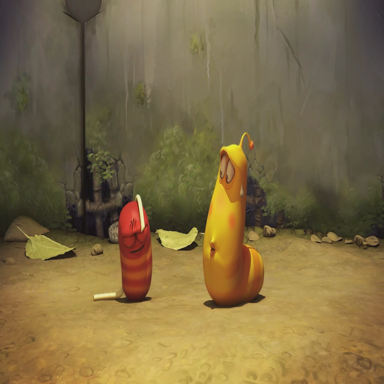

In [30]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [40]:
#freezing
cnt = 0
for child in model.children():
  for name, para in child.named_parameters():
    cnt += 1
    if cnt <= 52 or (cnt > 150 and cnt < 259):
      para.requires_grad = False

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [ ]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

In [ ]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(1):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

In [45]:
#model save
torch.save(model.state_dict(), '')

## Inference

Now that we've trained the model, let's load the Maradona image and perform inference on it.

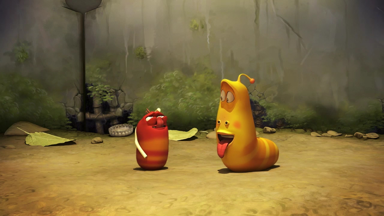

In [ ]:
load image
example = dataset[75]
print(example)
image = example["image"]
print(image)
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of football players.

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

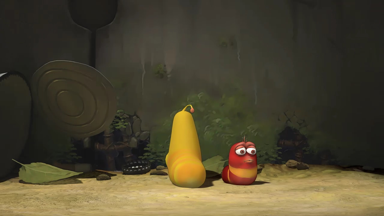

text : red is chewing something with a bored face.
result : red is chewing something with a bored face.


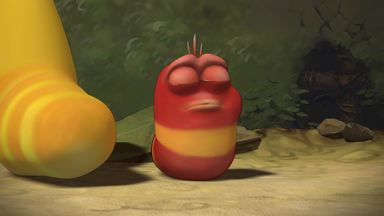

text : red is chewing something with a bored face.
result : red is chewing something with a bored face.


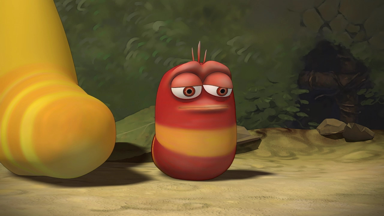

text : red is bored.
result : red is bored.


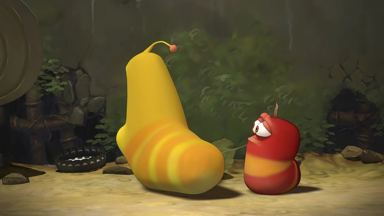

text : red looks at yellow
result : red looks at yellow


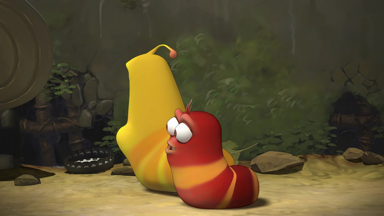

text : red tries to look at yellow's face. red finds something
result : red looks at yellow


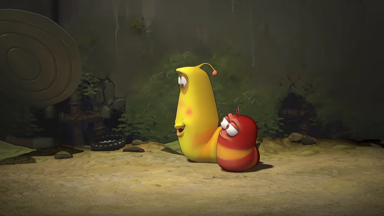

text : something was liquid and it is absorbed into the ground. Yellow concentrates at it as if something is going to grow up from there. Red is wondering about what yellow is doing. Red is still bored
result : red and yellow bite and kiss one spaghetti noodle


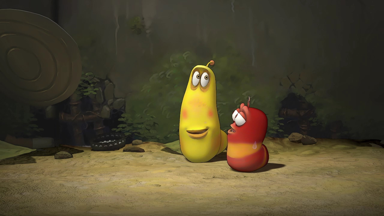

text : yellow eats mushroom. Red is surprised.
result : yellow eats mushroom. red is surprised.


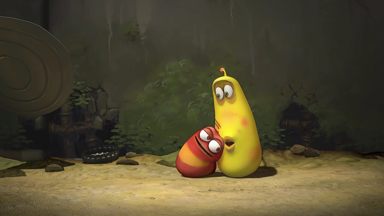

text : red pushes yellow to right side.
result : red pushes yellow to right side.


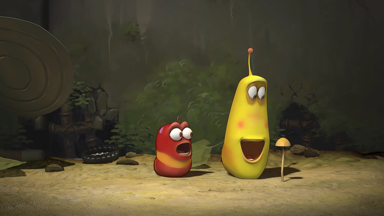

text : again, yellow eats the mushroom and red is confused and surprised
result : red is now on the left side of yellow


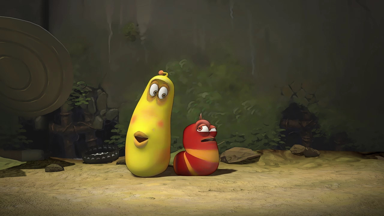

text : red tries to change the position with yellow again.
result : red tries to change the position with yellow again.


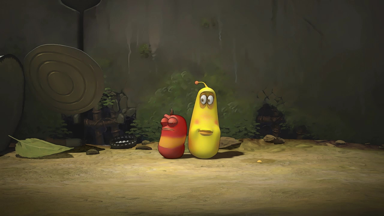

text : red is now on the left side of yellow and the liquid fell off on the ground closer to yellow
result : red is still looking up


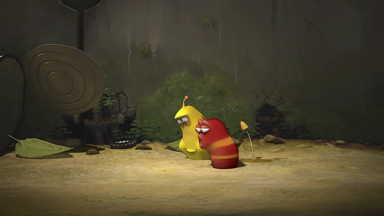

text : yellow ate the mushroom and red is surprised. Mushroom growed on the closer side to the yellow
result : red and yellow are standing and something is growing from the ground


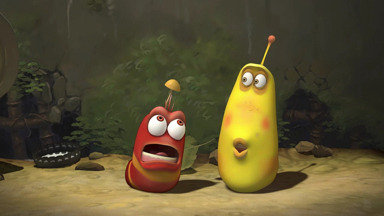

text : yellow is looking at red and something grew up on red's head
result : red is still looking up


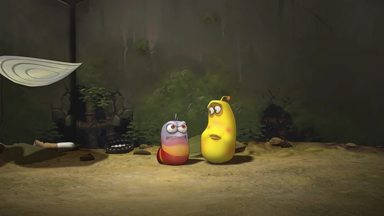

text : red is frustrated. Yellow is looking at red
result : red is frustrated. yellow is looking at red


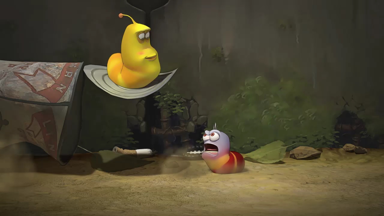

text : red is looking at yellow furiously. Yellow is on the can
result : red is looking at yellow furiously. yellow is on the can


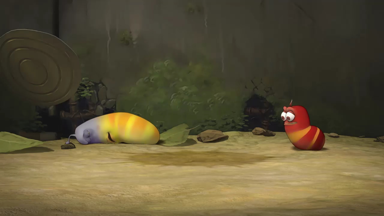

text : yellow is lying, fainted and the liquid is absorbed on the ground. Red is looking at the absorbed liquid
result : red is waiting for the mushroom to grow up


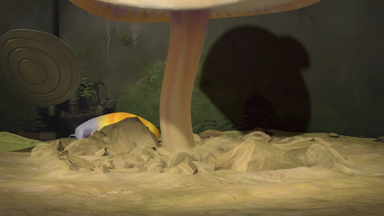

text : a giant mushroom is growing up
result : a giant mushroom is growing up


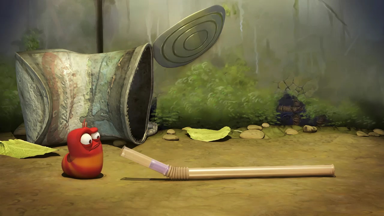

text : Red is looking at the remaining drink on the straw.
result : red is standing with its mouth open, staring at the remaining drink on the straw.


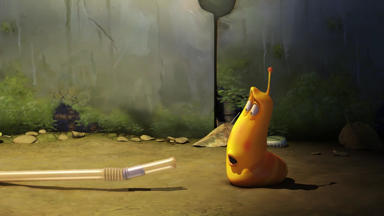

text : Yellow is looking at the remaining drink on the straw.
result : yellow is looking at the remaining drink on the straw.


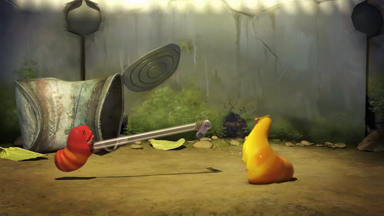

text : Red is hitting Yellow with a straw that has some drink left in it.
result : red is hitting yellow with a straw with drink left in it, and yellow is going flying.


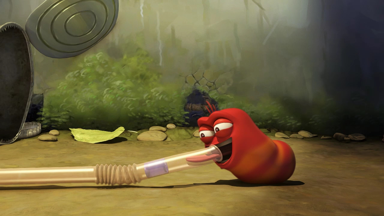

text : Red is trying to eat the remaining drink on the straw.
result : red is trying to eat the remaining drink on the straw.


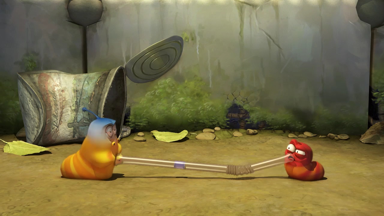

text : Red is trying to eat the remaining drink on the straw, and Yellow is also trying to eat the remaining drink on the straw.
result : red is trying to eat the remaining drink on the straw, and yellow is also trying to eat the remaining drink on the straw.


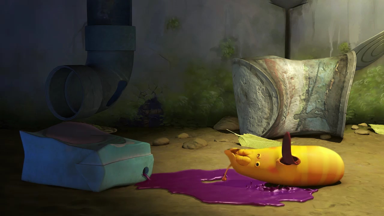

text : Yellow fell over the spilled drink.
result : yellow fell over the spilled drink.


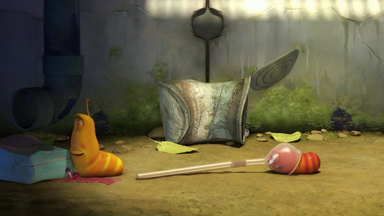

text : Red is getting stuck in a straw, and Yellow is eating a spilled drink.
result : red is getting hit by a fart and falling down


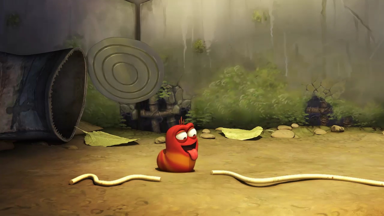

text : red is standing with its mouth open, staring at the spaghetti noodle
result : red is standing with its mouth open


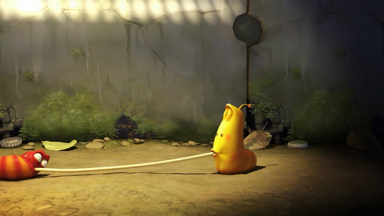

text : yellow is eating a spaghetti noodle, and red, who is biting into the noodle, is being pulled toward yellow
result : yellow is eating a spaghetti noodle, and red, who is biting into the noodle, is being pulled toward yellow


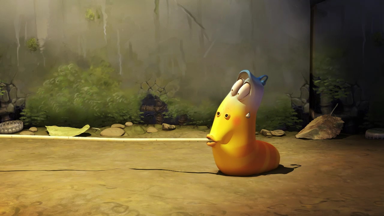

text : Someone pulled on the spaghetti noodles and yellow panicked as they were dragged away
result : someone pulled the spaghetti noodles and yellow panicked


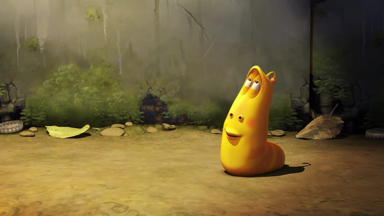

text : yellow feels paradise
result : yellow eats something


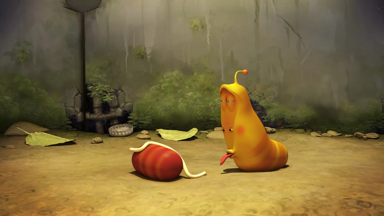

text : red is lying down with spaghetti noodles on top of his body and yellow is trying to eat them with his tongue out
result : red is lying down with spaghetti noodles on top of his body, and yellow is trying to eat them with his tongue out


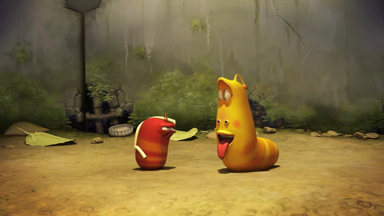

text : red stands with a spaghetti noodle on top of his body and sticks his tongue out while looking at the noodle. yellow sticks his tongue out and looks at it
result : red stands with a spaghetti noodle on top of his body and sticks his tongue out while looking at the noodle. yellow sticks his tongue out and looks at it


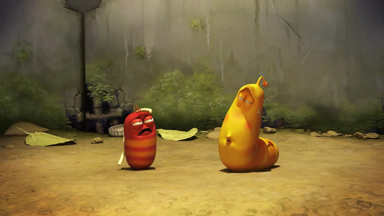

text : red is holding his spaghetti noodles in front of him, and yellow is looking at him pityingly
result : red is standing with spaghetti noodles stuck to him and yellow is panicking


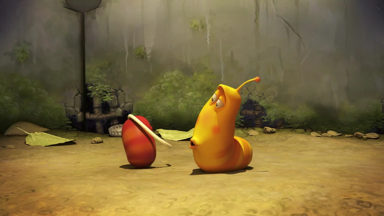

text : red is standing with spaghetti noodles stuck to him and yellow is panicking
result : red shakes himself to get the spaghetti noodles off his body, yellow looks on wistfully


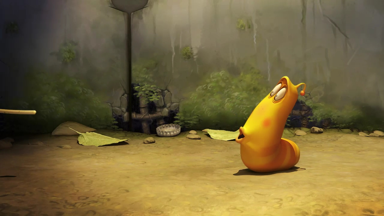

text : Red takes a bite out of his spaghetti noodle, and Yellow looks on in amazement
result : yellow looks up in surprise


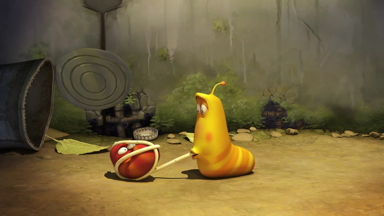

text : Red is lying down with spaghetti noodles wrapped around his body, and Yellow is eating them to free him
result : red is lying down with spaghetti noodles wrapped around his body, and yellow is eating them


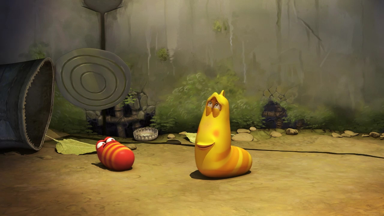

text : Red pokes at Yellow, and Yellow looks satisfied
result : red is down and yellow is happy


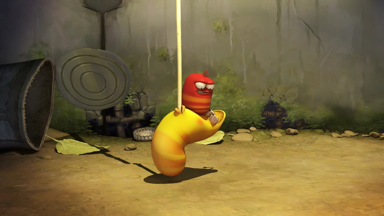

text : A spaghetti noodle hanging down from the top with Yellow holding it in his mouth and Red standing over Yellow
result : a spaghetti noodle hanging down from the top with yellow holding it in his mouth and red standing over yellow


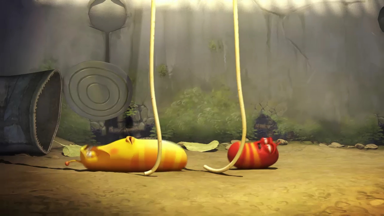

text : Red and Yellow each fell to the side of the spaghetti noodles
result : red and yellow are lying next to their respective spaghetti noodles


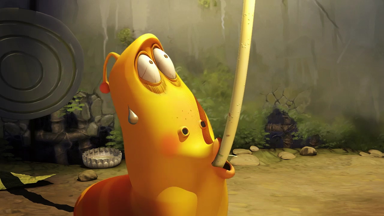

text : Yellow has a spaghetti noodle in his mouth and is very flustered
result : yellow has a spaghetti noodle in his mouth and is very flustered


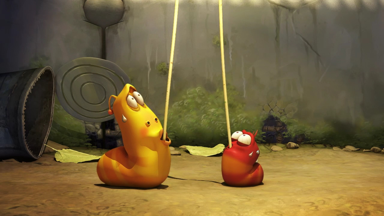

text : Red and Yellow have one spaghetti noodle in their mouths and both look at the sky in confusion
result : red and yellow have one spaghetti noodle in their mouths and both look at the sky in confusion


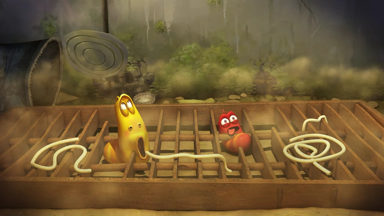

text : Red and yellow are lying on the sewer lid
result : red and yellow are lying on a sewer lid, with red throwing up and yellow looking satisfied


In [47]:
# load image

for i in range(0, 800, 20):
  example = dataset[i]
  image = example["image"]
  text = example["text"]
  width, height = image.size
  display(image.resize((int(0.3*width), int(0.3*height))))
  print("text : " + text)

  inputs = processor(images=image, return_tensors="pt").to(device)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  print("result : " + generated_caption)